In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import numpy
import torch.utils.data
from sklearn.model_selection import train_test_split

# Display Dataset

In [8]:
import sys
sys.path.append('..')

from Datasets.MackeyGlassDataset import MackeyGlassDataset
Mglass1 = MackeyGlassDataset(1000, 5, tau=17, seed=0)
Mglass2 = MackeyGlassDataset(10000, 2, tau=20, seed=0)

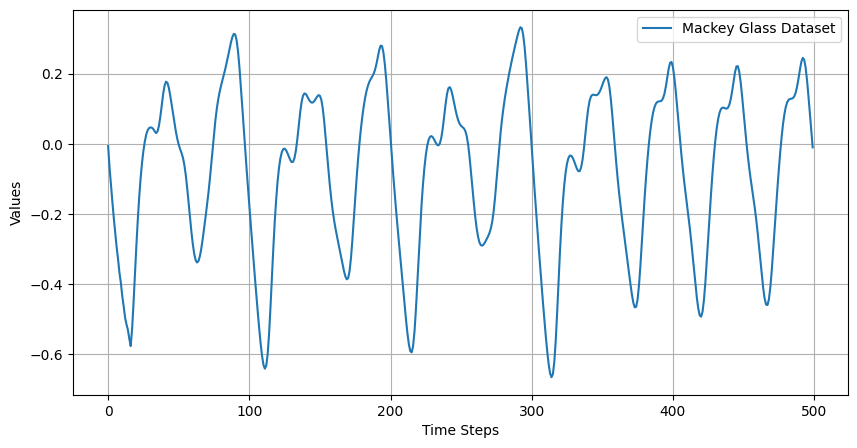

In [31]:
dataset = torch.utils.data.DataLoader(Mglass1, batch_size=1, shuffle=False)
dataset = np.array([data[0] for data in dataset]).reshape(-1, 1)
# loop through the input data (data[0]) and convert it to numpy array with shape of colomn vector

plt.figure(figsize=(10, 5))
plt.plot(dataset[:500], label='Mackey Glass Dataset')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

### Splits of dataset

In [12]:
train_test_ratio = 0.8
train_size = int(len(dataset) * train_test_ratio)
test_size = len(dataset) - train_size

train_data, test_data = train_test_split(dataset, train_size=train_size, test_size=test_size)

train_data.shape, test_data.shape

((3996, 1), (999, 1))

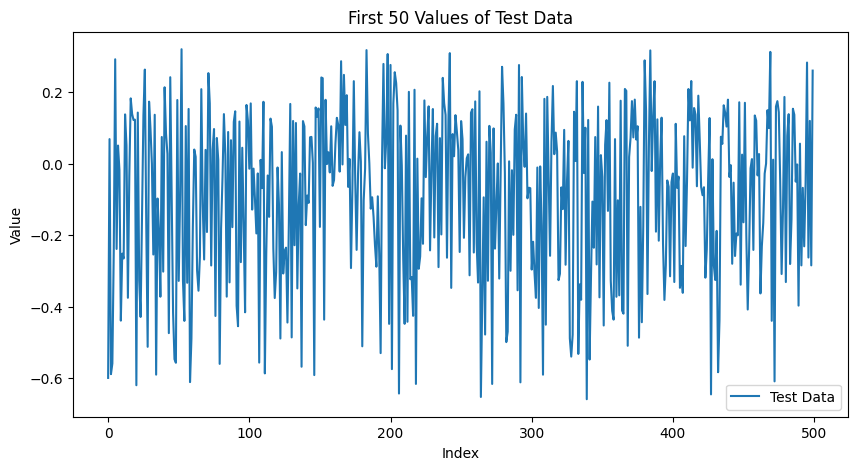

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(test_data[:500], label='Test Data')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('First 50 Values of Test Data')
plt.show()

In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('CPU is available')


GPU is available


In [15]:
#train_data = torch.tensor(np.array([data[0] for data in train_dataset]).reshape(-1, 1)).to(device)
#test_data = torch.tensor(np.array([data[0] for data in test_dataset]).reshape(-1, 1)).to(device)
#train_data

# ESN 

In [16]:
from Models.Echostate import ESN

esn = ESN(input_dim = 1, reservoir_dim = 200, output_dim = 1)
esn_prime = ESN(input_dim = 1, reservoir_dim = 200, output_dim = 1) 

esn.to(device)
esn.freeze_reservoir()  # Freeze reservoir weights

esn_prime.to(device)
esn_prime.freeze_reservoir()  # Freeze reservoir weights

# Define optimizer and criterion for the readout layer
#optimizer = torch.optim.Adam(esn.readout.parameters(), lr=0.05)
criterion = nn.MSELoss()
type(esn.readout)

torch.nn.modules.linear.Linear

In [17]:
inputs, targets = Mglass1[0]

inputs = inputs.to(device) 
targets = targets.to(device)

for name, param in esn.named_parameters():
    print(f"{name} is on {param.device}")

print(inputs.device, targets.device)


readout.weight is on cuda:0
readout.bias is on cuda:0
cuda:0 cuda:0


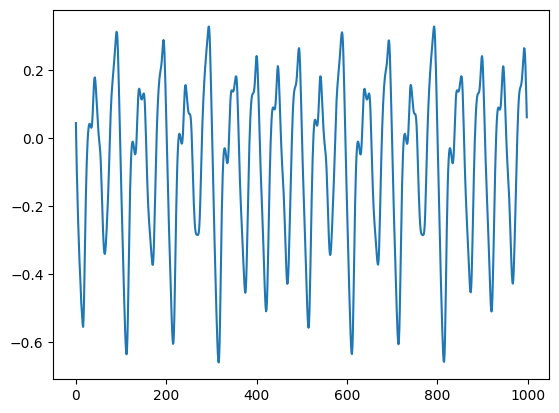

In [18]:
plt.plot(targets.cpu().numpy(), label='Input')

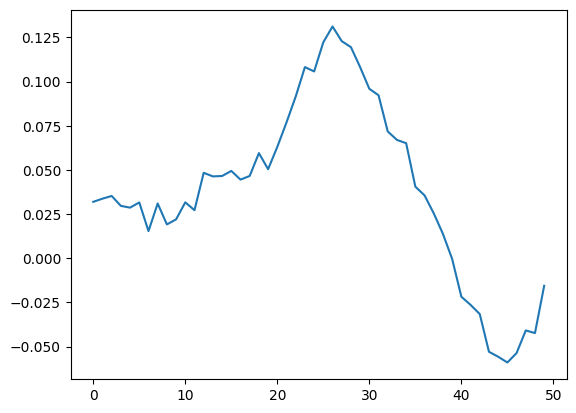

In [19]:
plt.plot(esn(inputs[:50]).detach().cpu().numpy(), label='Prediction')

In [20]:
optimizer_prime = torch.optim.Adam(esn_prime.readout.parameters(), lr=0.05)
losses = esn_prime.Train(inputs, targets, epochs=100, lr=0.05, 
                         print_every=10)

Epoch 0, Loss: 0.09118235111236572
Epoch 10, Loss: 0.022964060306549072
Epoch 20, Loss: 0.00407388573512435
Epoch 30, Loss: 0.0015237367479130626
Epoch 40, Loss: 0.0008948002359829843
Epoch 50, Loss: 0.00038730213418602943
Epoch 60, Loss: 0.0002128530468326062
Epoch 70, Loss: 0.00015778462693560869
Epoch 80, Loss: 0.00014085081056691706
Epoch 90, Loss: 0.00012259795039426535
Epoch 99, Loss: 0.00011112735228380188


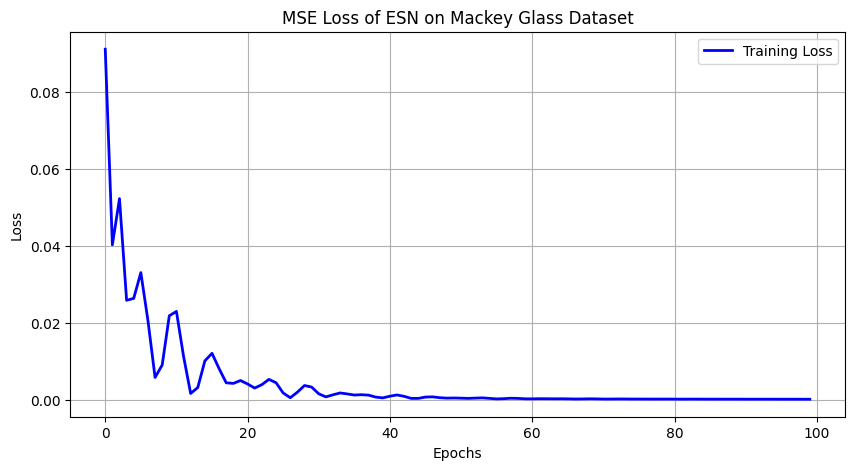

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(losses.cpu().detach().numpy(), label='Training Loss', color='blue', linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MSE Loss of ESN on Mackey Glass Dataset')
plt.legend()
plt.grid(True)
plt.savefig("Loss.png", dpi=300)

In [22]:
Reservoir_states = esn.res_states().to(device)
Readout = esn.readout_layer().to(device)
Reservoir_state = esn.res_state().to(device)
reservoir_W = esn.res_w().to(device)
W_in = esn.w_in().to(device)
Reservoir_states.size(), Reservoir_state.size(), Readout

(torch.Size([50, 200]),
 torch.Size([200]),
 Linear(in_features=200, out_features=1, bias=True))

In [23]:
r_states_last = Reservoir_states[-1]
preds = inputs[-1]
preds

tensor([0.1146], device='cuda:0')

In [24]:
r_states_last = torch.tanh(torch.matmul(reservoir_W, r_states_last)
                  + torch.matmul(W_in, inputs[-1]))

pred = esn.readout(r_states_last)
preds = torch.cat((preds, pred), dim=0)

In [25]:
#TODO
# 1. Prediction method should update the reservoir states. 
# 2. Add prediction loop to get x number of prediction.

In [26]:
pred_targets = targets.detach().cpu().numpy()

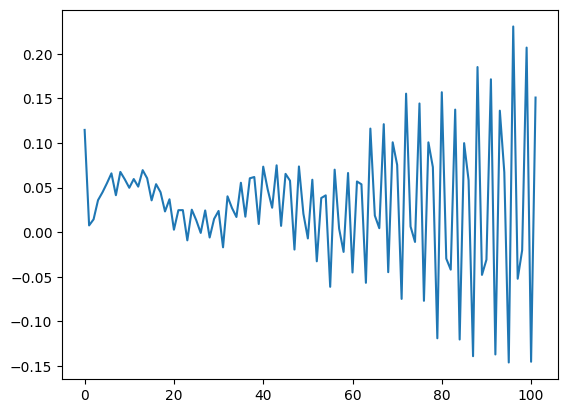

In [27]:
num_predictions = 100  # Number of predictions to generate
for _ in range(num_predictions):
    r_states_last = torch.tanh(torch.matmul(reservoir_W, r_states_last)
                      + torch.matmul(W_in, preds[-1].unsqueeze(0)))
    pred = esn.readout(r_states_last)
    preds = torch.cat((preds, pred), dim=0)

plt.plot(preds.cpu().detach().numpy())

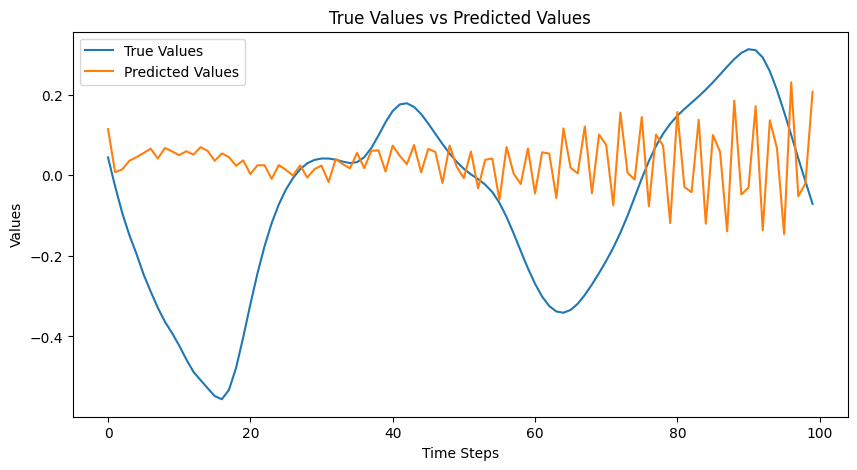

In [28]:
# Assuming preds contains the predicted values and test_data contains the true values
plt.figure(figsize=(10, 5))
plt.plot(pred_targets[:num_predictions], label='True Values')
plt.plot(preds.cpu().detach().numpy()[:num_predictions], label='Predicted Values')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('True Values vs Predicted Values')
plt.show()